# Grid Optimization Analysis

In [44]:
import matplotlib.cm
import math
import numpy as np
import qcportal as ptl
from IPython.display import display, HTML
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, TextArea
from sklearn import decomposition # PCA
from sklearn.cluster import AgglomerativeClustering
from tqdm.notebook import tqdm, trange

# Local
from util import calc_improper_01

In [3]:
# Interactive plots
%matplotlib notebook

## Loading the Data

In [4]:
CLIENT = ptl.FractalClient()
DATASET = CLIENT.get_collection('GridOptimizationDataset',
                                'OpenFF Trivalent Nitrogen Set 1 (deprecated)')
MOLECULE_IDS = [
    DATASET.get_entry(index).initial_molecule for index in DATASET.df.index
]
MOLECULES = CLIENT.query_molecules(id=MOLECULE_IDS)
METADATA_ENTRIES = [
    DATASET.get_entry(index).object_map['default'] for index in DATASET.df.index
]
# get all grid optimization calculations from the entire dataset
ENTRIES = CLIENT.query_procedures(METADATA_ENTRIES)

# Expected number of optimization frames
NUM_FRAMES = 21

# Remove molecules that have no optimizations
GOOD_MOLECULES = []
GOOD_ENTRIES = []
for idx, entry in enumerate(ENTRIES):
    final_energies = entry.get_final_energies()
    if len(final_energies) != NUM_FRAMES:
        print(f"Molecule {idx:3} ({MOLECULES[idx].get_molecular_formula()}) has {len(final_energies)} frames")
    else:
        GOOD_MOLECULES.append(MOLECULES[idx])
        GOOD_ENTRIES.append(ENTRIES[idx])

Molecule  66 (C22Cl2H24NO6PS) has 0 frames
Molecule  83 (C16H37NO2P2S2) has 0 frames
Molecule  84 (C22H24NO2PS) has 0 frames
Molecule  85 (C20H21N3O4S) has 0 frames
Molecule 138 (C4H6N2O) has 0 frames
Molecule 141 (C19H13NO3S) has 0 frames
Molecule 157 (C31H45N3O8S3) has 0 frames
Molecule 160 (C21H22N2O6S2) has 0 frames
Molecule 175 (C28H22NO2P) has 0 frames
Molecule 193 (C22H24N6O6S2) has 0 frames
Molecule 204 (C12H21N2P) has 0 frames
Molecule 218 (BrC9H8N3) has 0 frames
Molecule 236 (C6H5N3) has 0 frames
Molecule 242 (C13H18N3O2) has 0 frames
Molecule 252 (C24H20NOP) has 0 frames
Molecule 277 (C12H11N2O3S) has 0 frames
Molecule 279 (C10H8N2O2) has 0 frames
Molecule 286 (C7H4INO3S) has 0 frames
Molecule 298 (C22H30N3P) has 0 frames


In [5]:
print(f"There are {len(GOOD_MOLECULES)} good molecules.")

There are 292 good molecules.


In [11]:
# Create vectors of the energies
ENERGIES = np.zeros(shape=(len(GOOD_ENTRIES), NUM_FRAMES))

for idx, entry in enumerate(GOOD_ENTRIES):
    final_energies = entry.get_final_energies()
    for frame_idx in range(NUM_FRAMES):
        ENERGIES[idx][frame_idx] = final_energies[(frame_idx,)]
    # Normalize the energies by subtracting the minimum energy
    min_energy = np.min(ENERGIES[idx])
    ENERGIES[idx] -= min_energy

# Apply PCA to reduce to 2d for plotting
pca_2d = decomposition.PCA(n_components=2)
ENERGIES_2D = pca_2d.fit_transform(ENERGIES)

In [53]:
# Retrieve the fitted molecule associated with each optimization frame.
# Retrieing each molecule may take a while.
FITTED_MOLECULES = [[None for i in range(NUM_FRAMES)] \
                     for j in range(len(GOOD_ENTRIES))]

for idx, entry in tqdm(tuple(enumerate(GOOD_ENTRIES))):
    # Retrieval may be slow.
    final_molecules = entry.get_final_molecules()
    for frame_idx in range(NUM_FRAMES):
        FITTED_MOLECULES[idx][frame_idx] = final_molecules[(frame_idx,)]

## Utilities

In [86]:
def plot_1d_scan(ax, index):
    """Plots a 1D scan of the given molecule onto the given Axis objext"""
    ax.plot(IDEAL_IMPROPERS, ENERGIES[index])
    ax.set_title(f"Molecule {index} | {GOOD_MOLECULES[index].get_molecular_formula()}")
    ax.set_xticks(IDEAL_IMPROPERS[0::2]) # Ticks are every other value in the ideal impropers

## Cleaning

Look for irregularities in the data.

### Improper Angle Tolerance

Look for grid optimization frames where the improper angle of the trivalent nitrogen differs from the desired amount by more than IMPROPER_TOLERANCE degrees. This is necessary because, even though the improper angle around the trivalent nitrogen is restrained during grid optimization, it may still vary during the calculation.

In [82]:
# Ideal improper angles for the optimization frames.
IDEAL_IMPROPERS = 4 * (np.arange(0,NUM_FRAMES,1) - NUM_FRAMES // 2)

# Maximum amount, in degrees, that the actual improper angle in a
# molecule can differ from the desired angle.
IMPROPER_TOLERANCE = 1e-5

In [83]:
def find_mismatch_impropers():
    """Does the work of finding the badly fitted molecules."""

    for idx, entry in tqdm(tuple(enumerate(GOOD_ENTRIES))):
        restraint_indices = entry.keywords.scans[0].__dict__['indices']
        assert len(restraint_indices) == 4, \
               f"There are {len(restraint_indices)} restrained atoms in entry {idx}."

        for frame_idx in range(NUM_FRAMES):
            molecule = FITTED_MOLECULES[idx][frame_idx]

            actual_angle = calc_improper_01.calc_improper_angle(
                molecule.geometry[restraint_indices[0]],
                molecule.geometry[restraint_indices[1]],
                molecule.geometry[restraint_indices[2]],
                molecule.geometry[restraint_indices[3]],
                True)
            ideal_angle = IDEAL_IMPROPERS[frame_idx]
            delta = abs(actual_angle - ideal_angle)

            if delta > IMPROPER_TOLERANCE:
                print(f"Entry {idx} ({molecule.name}), frame {frame_idx} |"
                      f" expected: {ideal_angle}, actual: {actual_angle}")

In [84]:
find_mismatch_impropers()

### Corner Detection

Detect 1D scan plots with corners in them. Corners are abnormal and may be indicative of a failure in the grid optimizations.

21 scans found with corners


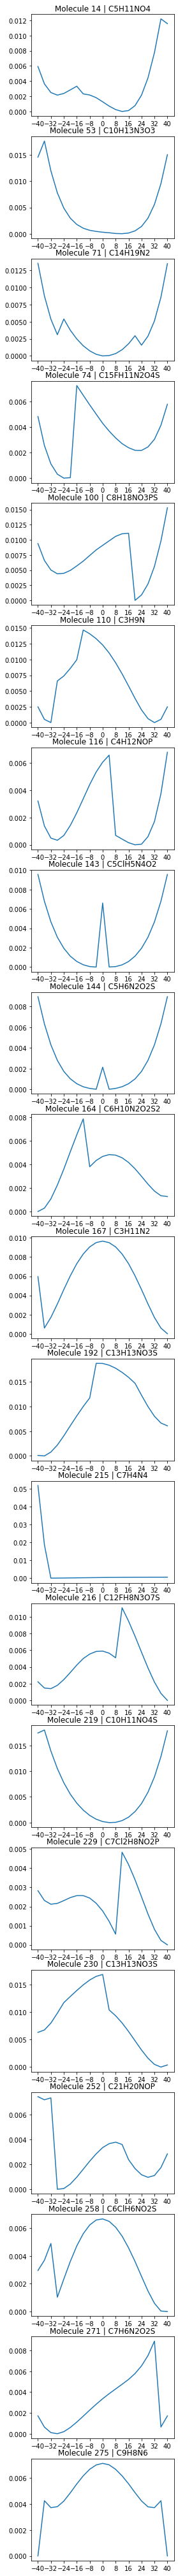

In [100]:
# Tells whether each entry has a corner in its plot
HAS_CORNER = np.zeros(len(GOOD_ENTRIES), dtype=bool)

# Detecting corners presents a slight challenge because we do not have
# continuous data. Here, we attempt to do it by checking if the left and
# right slopes at a point in the plot have opposite signs and differ by
# at least CORNER_DIFFERENCE_MAGNITUDE.
CORNER_DIFFERENCE_MAGNITUDE = 0.001
for idx, energy_series in enumerate(ENERGIES):
    for i in range(1, NUM_FRAMES - 1):
        # Slope is the energy divided by the number of degrees (4)
        left_slope = (energy_series[i] - energy_series[i - 1]) / 4
        right_slope = (energy_series[i + 1] - energy_series[i]) / 4

        are_opposite_direction = \
            (left_slope < 0 and right_slope > 0) or \
            (left_slope > 0 and right_slope < 0)
        have_sufficient_difference = \
            abs(left_slope - right_slope) >= CORNER_DIFFERENCE_MAGNITUDE

        if are_opposite_direction and have_sufficient_difference:
            HAS_CORNER[idx] = True
            break

num_plots_with_corners = np.sum(HAS_CORNER)
print(f"{num_plots_with_corners} scans found with corners")
fig, ax = plt.subplots(num_plots_with_corners,1,figsize=(4, num_plots_with_corners * 3.5))
plot_idx = 0
for idx in range(len(HAS_CORNER)):
    if HAS_CORNER[idx]:
        plot_1d_scan(ax[plot_idx], idx)
        plot_idx += 1

## Visualization

Get a better idea of what the data looks like using PCA.

In [107]:
def pca_plot(cluster_ids=None):
    """Create a plot of the PCA.
    
    When one hovers over the points, they can see the normalized 1D
    scan for it, as well as the index and molecular formula.
    |cluster_ids| is an array such that cluster_ids[i] is the cluster id
    of molcule i.
    """
    %matplotlib notebook
    
    if cluster_ids is None:
        cluster_ids = np.zeros(len(GOOD_ENTRIES))
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    pca_ax = ax[0]  # Scatterplot of the energies after 2D PCA
    scan_ax = ax[1] # 1D scan of molecule energies
    
    scatter_path = pca_ax.scatter(ENERGIES_2D[:,0],
                                  ENERGIES_2D[:,1],
                                  c=cluster_ids,
                                  cmap=matplotlib.cm.get_cmap("tab20c"))
    pca_ax.set_title("2D PCA of Grid Optimization Energies")

    def show_plot(event):
        """
        A callback that handles mouse events and shows the molecule
        in the plot.
        """
        mouse_hovering, info = scatter_path.contains(event)
        if mouse_hovering:
            # Index within the scatter plot points where the mouse hovers.
            index, = info["ind"]
            # Set the 1D scan plot to correspond to the point.
            scan_ax.clear()
            plot_1d_scan(scan_ax, index)
        fig.canvas.draw_idle()
    # Add the callback.
    fig.canvas.mpl_connect('motion_notify_event', show_plot)

    plt.show()

<IPython.core.display.Javascript object>


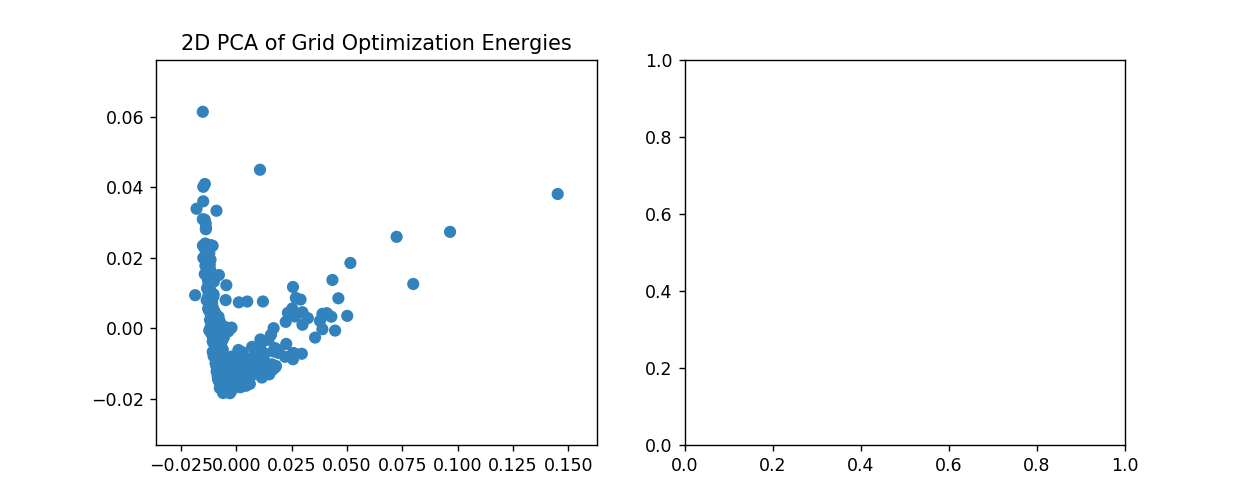

In [109]:
# Rerun if interactivity not working
pca_plot()

## Clustering
Clustering the molecules by energy profile.

In [110]:
def cluster_ids_to_clusters(cluster_ids):
    """Get a list where entry i lists the molecules in cluster i."""
    num_clusters = len(set(cluster_ids))
    clusters = [[] for _ in range(num_clusters)]
    for mol_idx,cid in enumerate(cluster_ids):
        clusters[cid].append(mol_idx)
    return clusters

def get_clusters(n_clusters=10):
    """Get the ids and clusters from clustering with n clusters.
    
    Indices correspond to molecules in GOOD_ENTRIES.
    """
    # Tells the cluster id of every molecule in GOOD_ENTRIES
    cluster_ids = AgglomerativeClustering(n_clusters=n_clusters,
                                          affinity="euclidean",
                                          linkage="ward").fit_predict(ENERGIES)
    return cluster_ids, cluster_ids_to_clusters(cluster_ids)

def plot_details_for_clusters(clusters):
    """Plot the 1D scans and other details of molecules in each cluster."""
    COLS = 4
    FIG_WIDTH = 13
    PLOT_HEIGHT = 3
    %matplotlib inline

    for cid,cluster in enumerate(clusters):
        display(HTML(f"<h1>Cluster {cid}</h1>"))
        rows = math.ceil(len(clusters[cid]) / COLS)
        fig, ax = plt.subplots(rows, COLS, figsize=(FIG_WIDTH, PLOT_HEIGHT * rows))
        fig.tight_layout() # Improve spacing between plots
        ax = np.atleast_2d(ax)

        idx = 0
        for r in range(rows):
            for c in range(COLS):
                if idx < len(cluster):
                    plot_1d_scan(ax[r,c], cluster[idx])
                idx += 1
        plt.show()

In [111]:
cluster_ids, clusters = get_clusters(30) # Modify number of clusters as needed

<IPython.core.display.Javascript object>


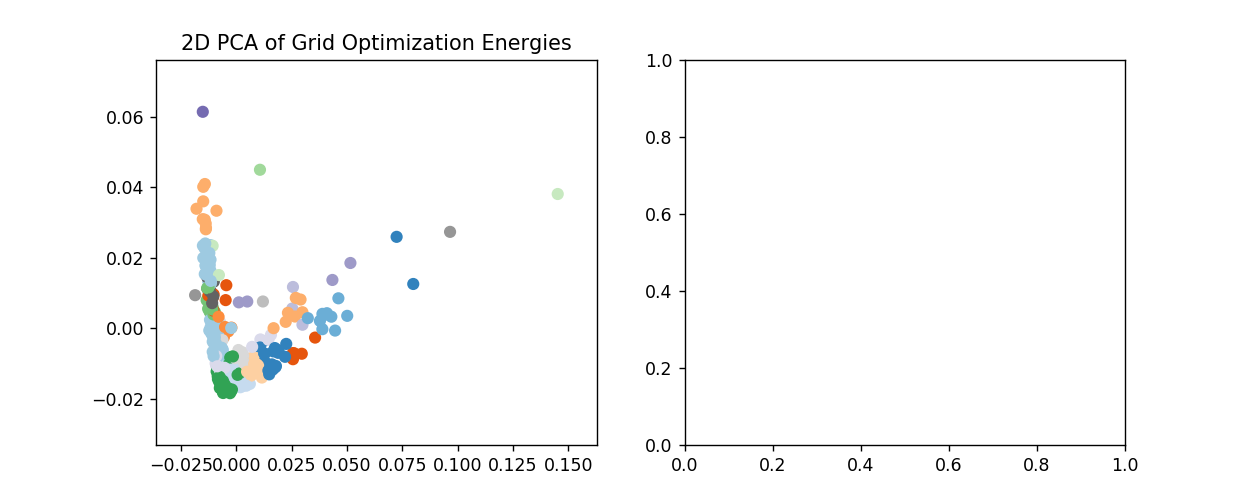

In [112]:
pca_plot(cluster_ids)

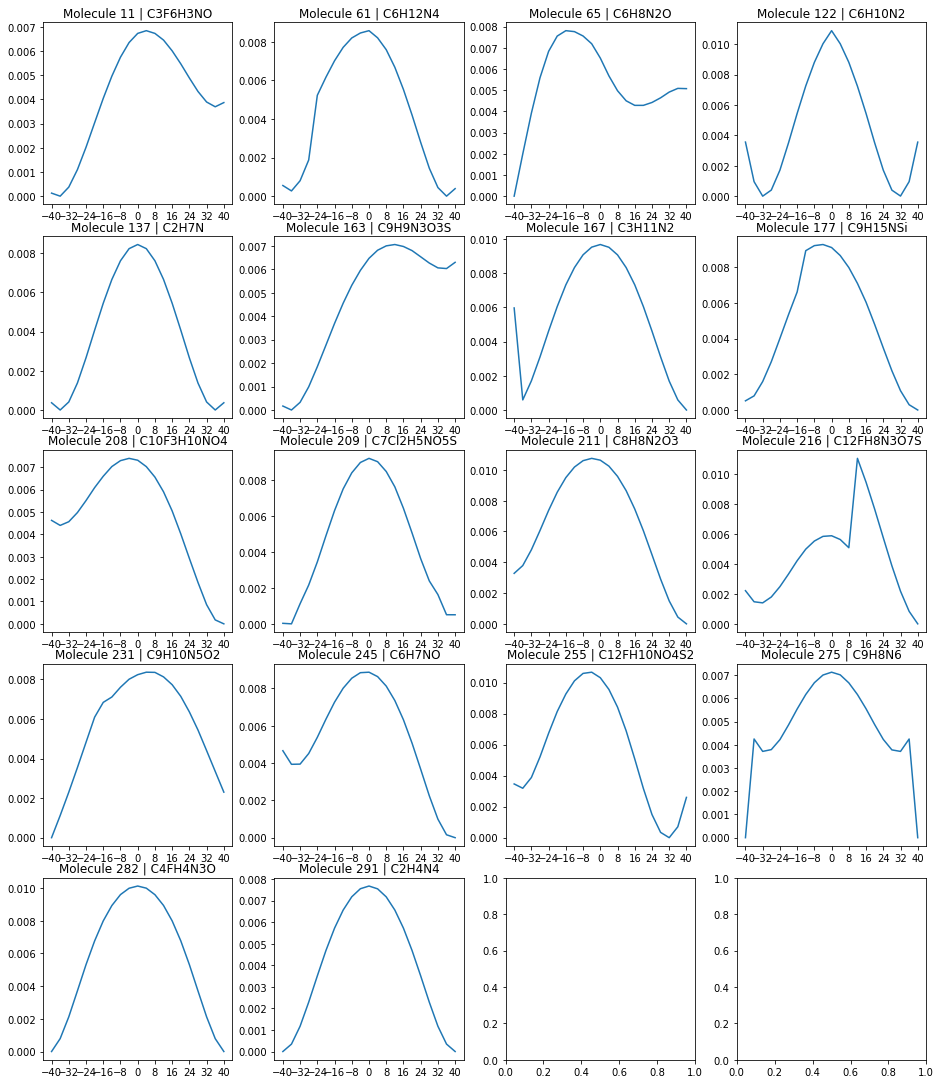

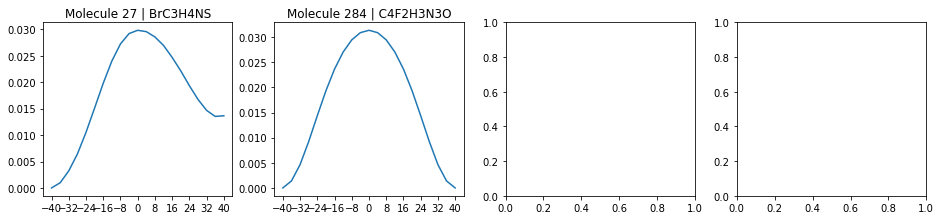

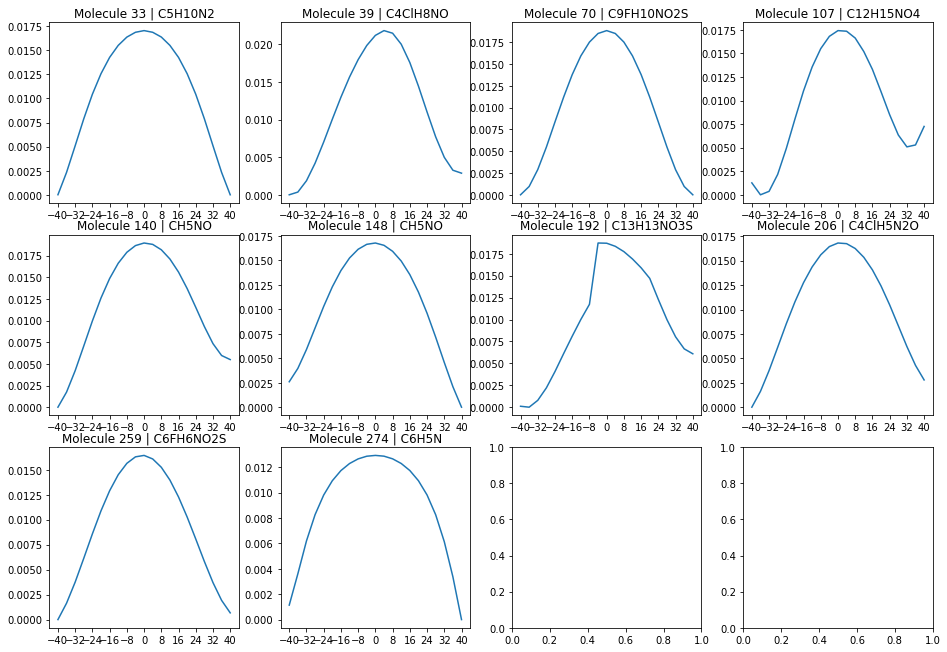

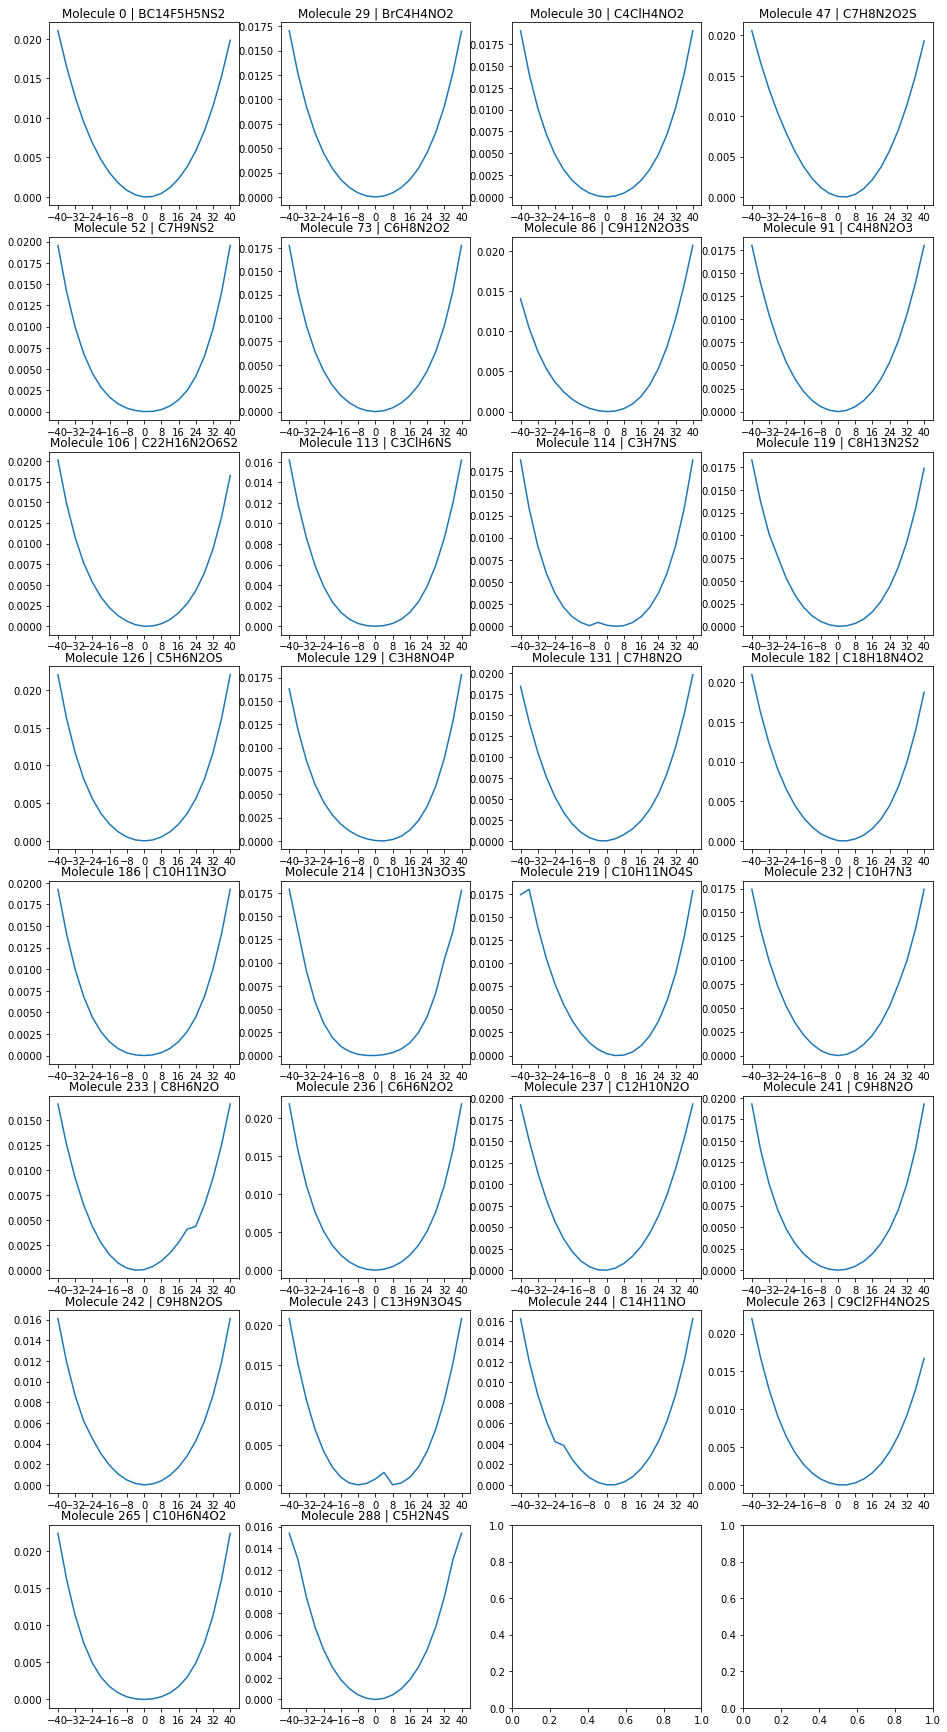

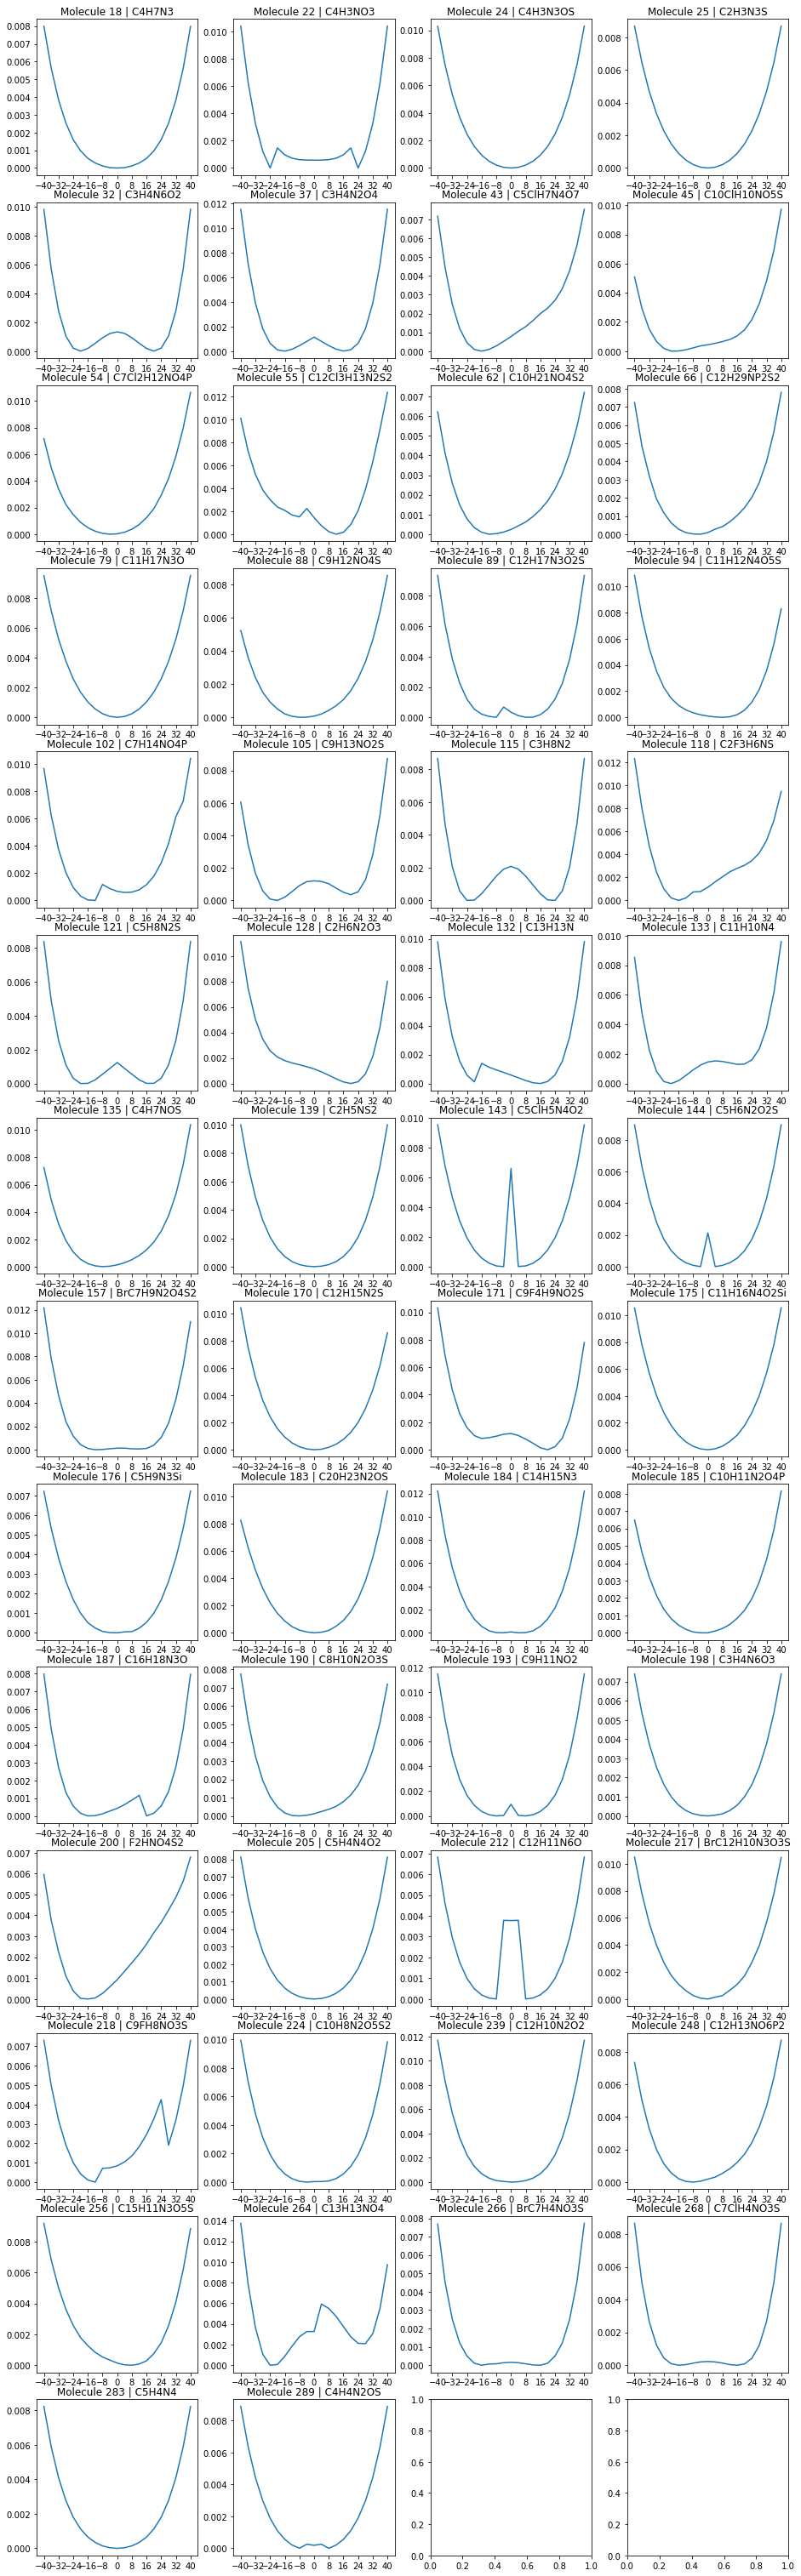

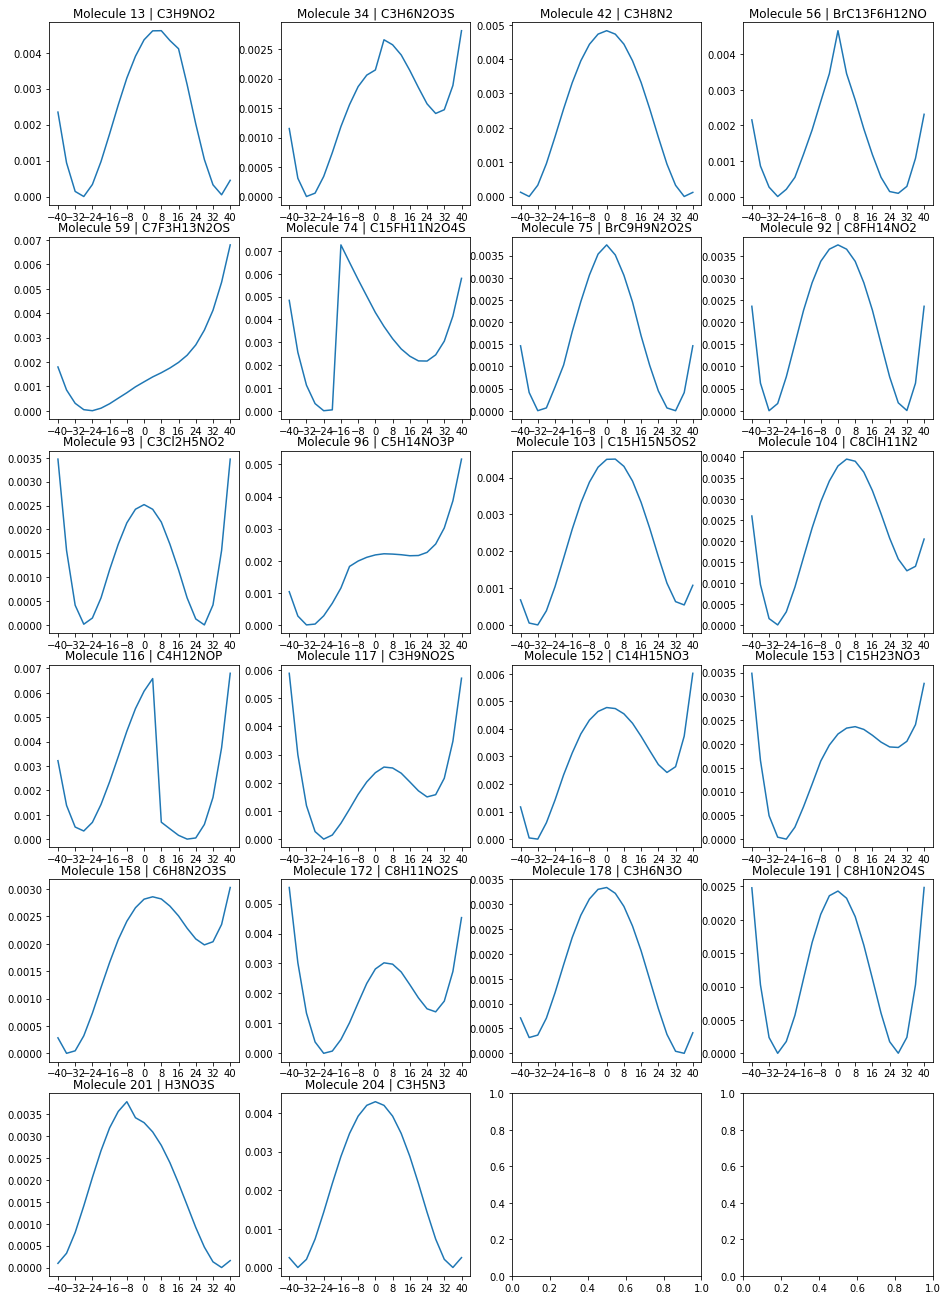

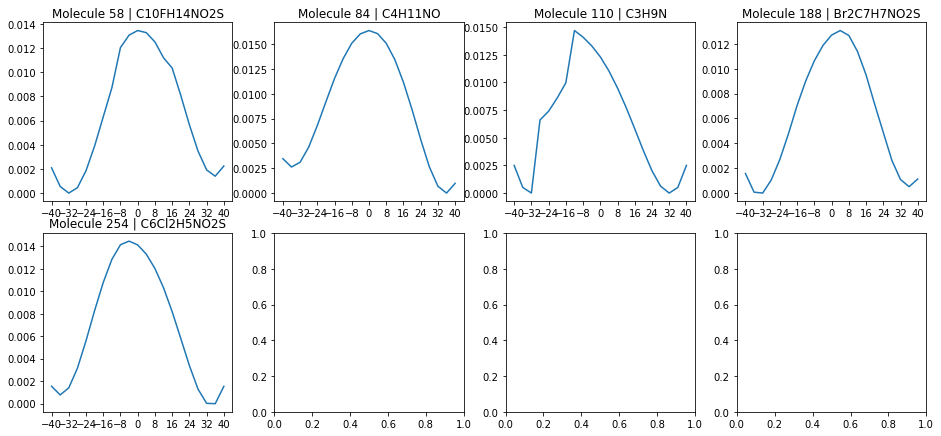

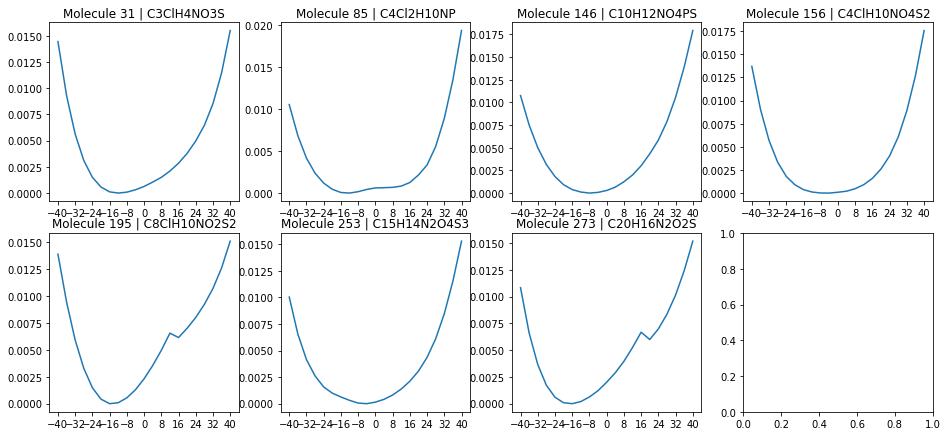

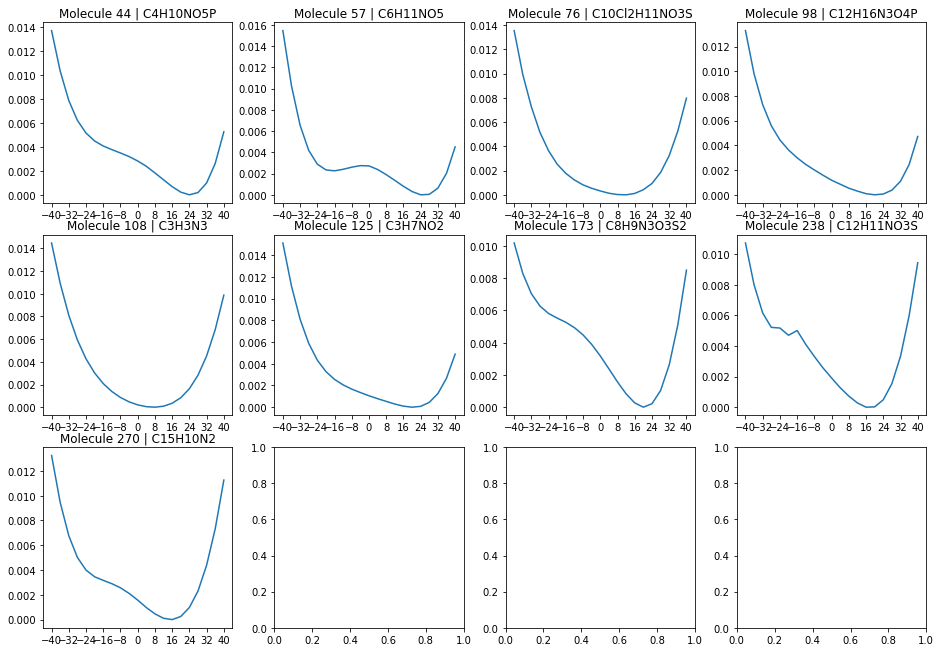

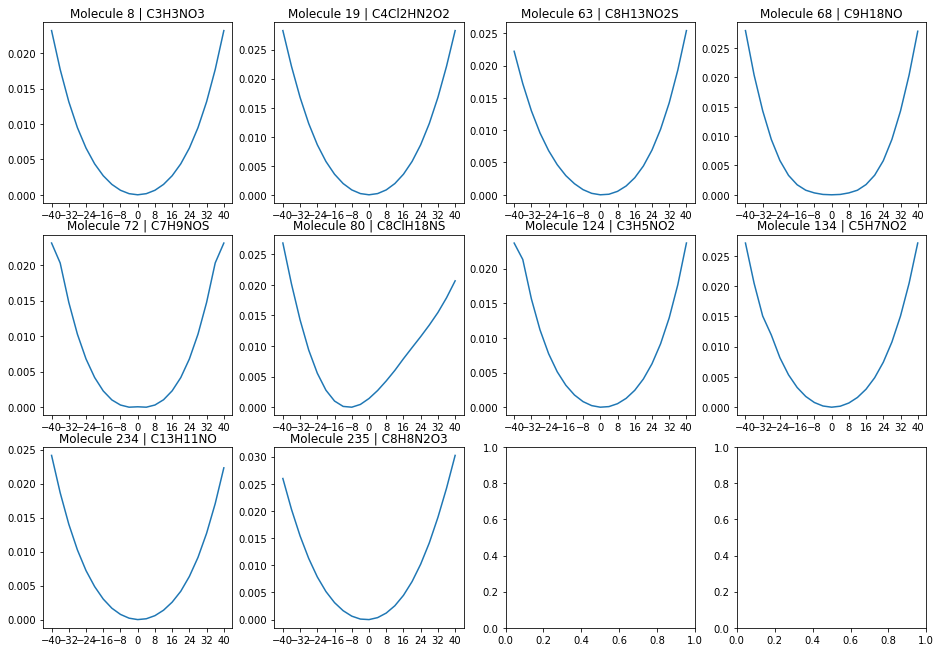

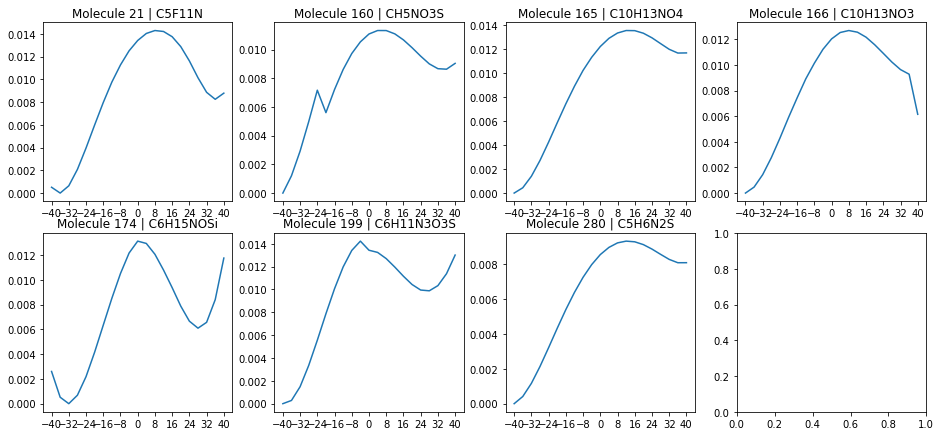

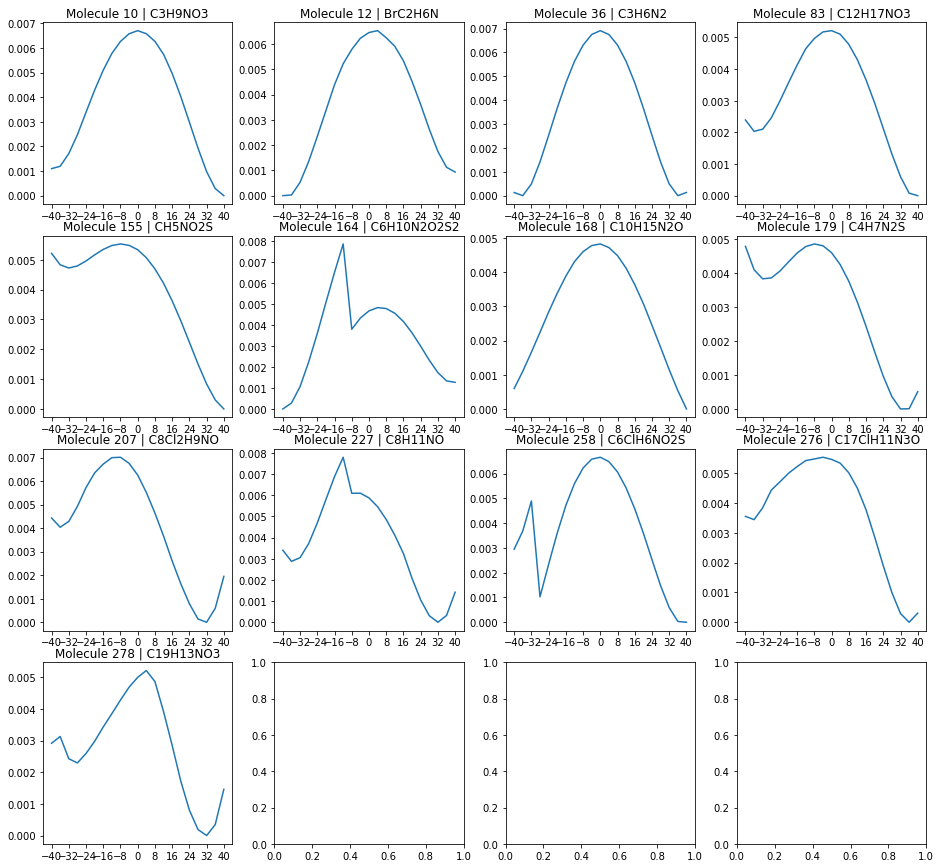

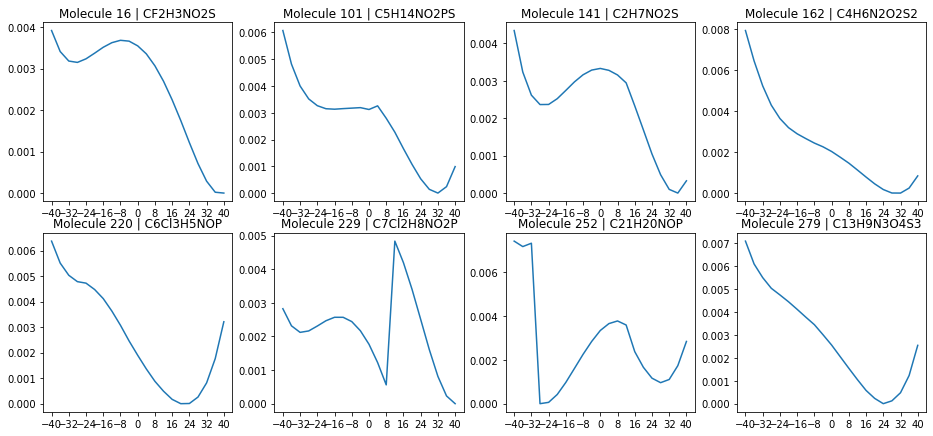

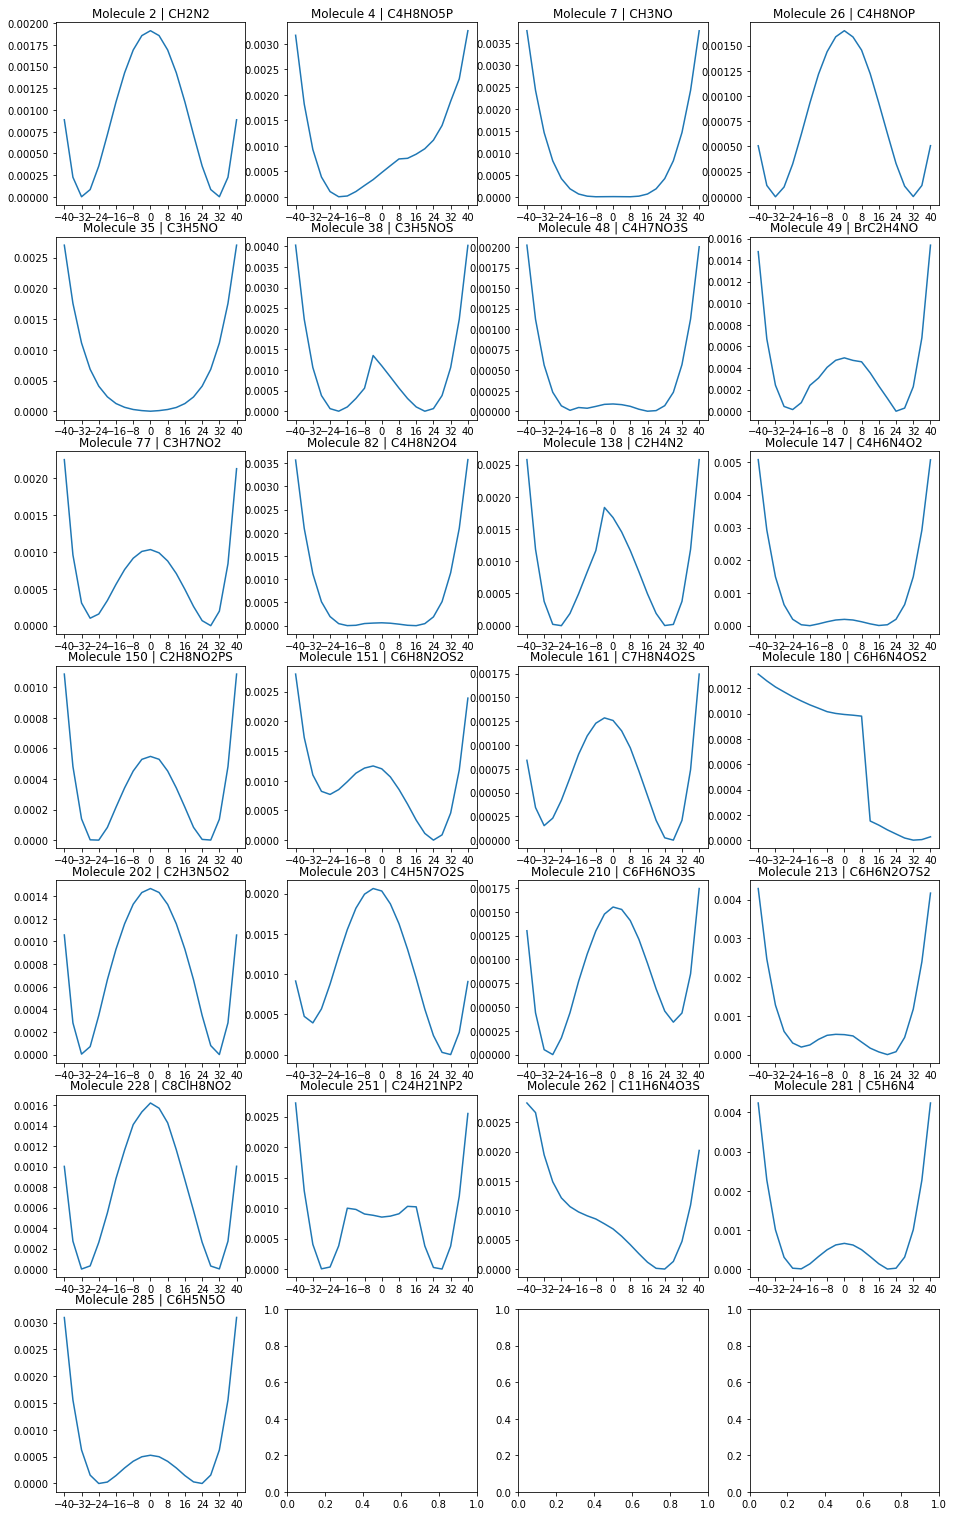

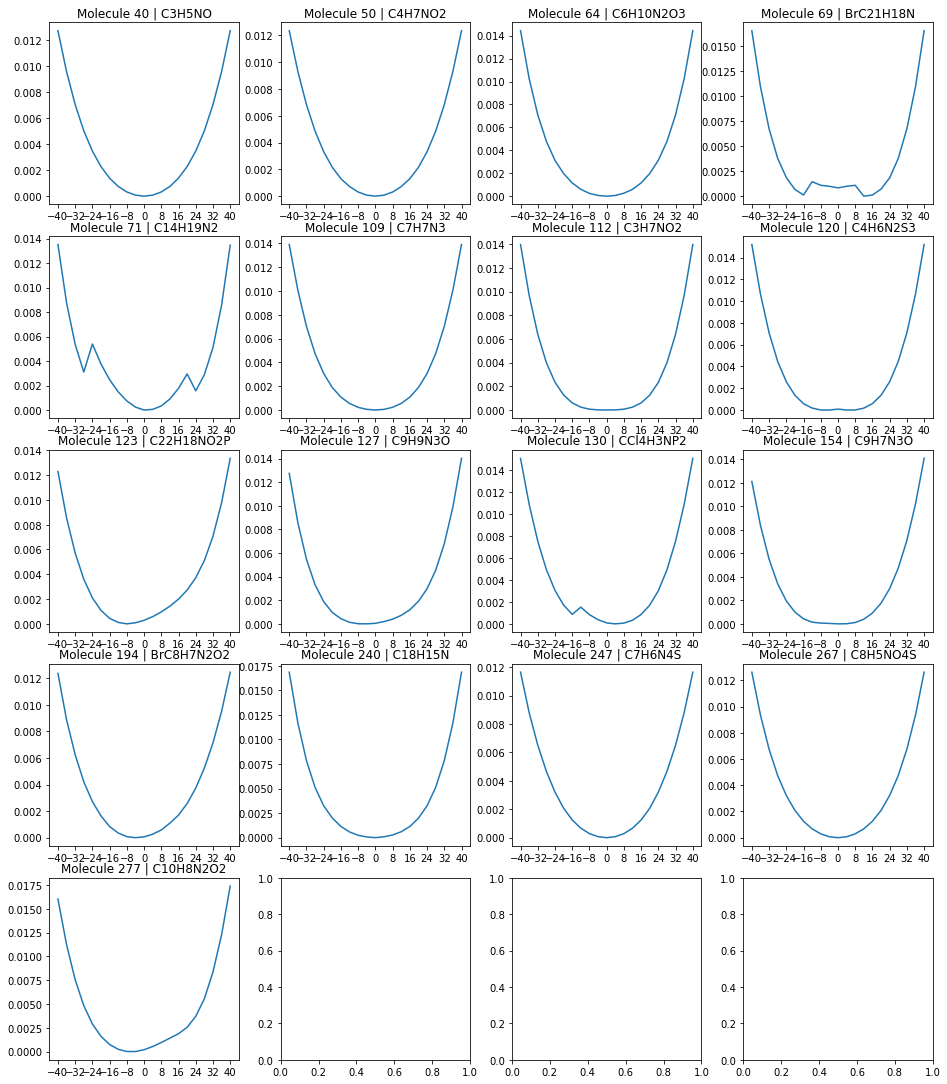

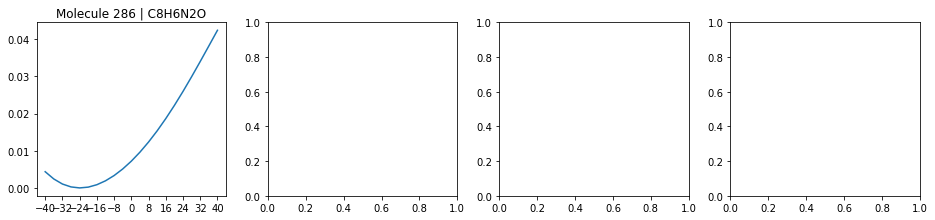

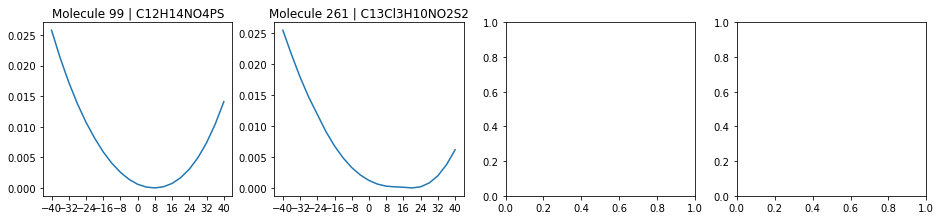

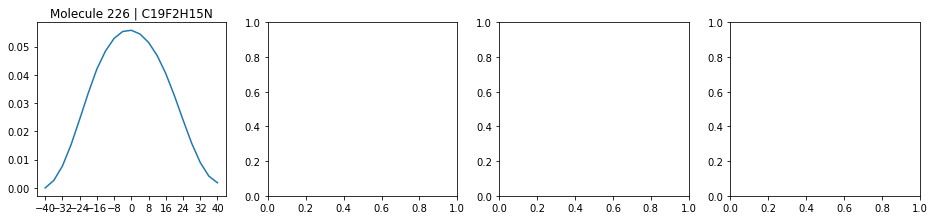

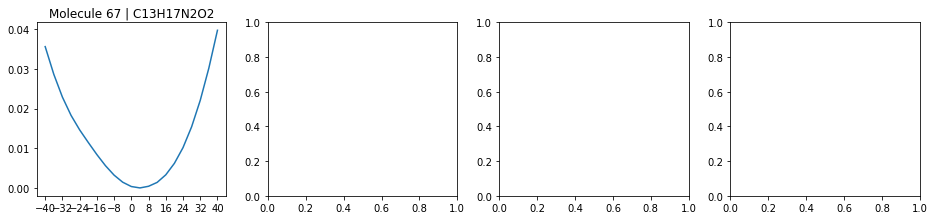

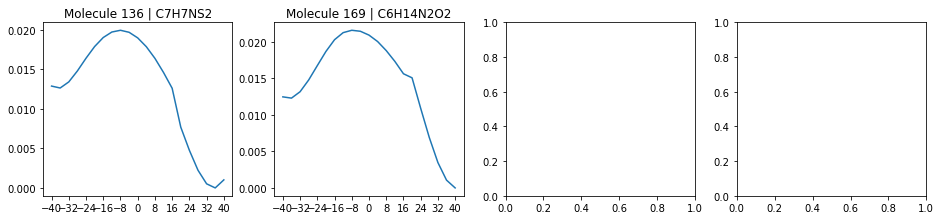

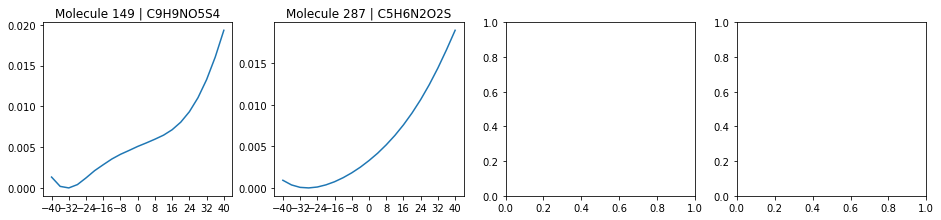

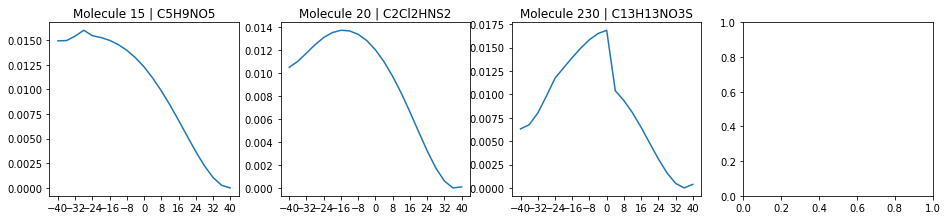

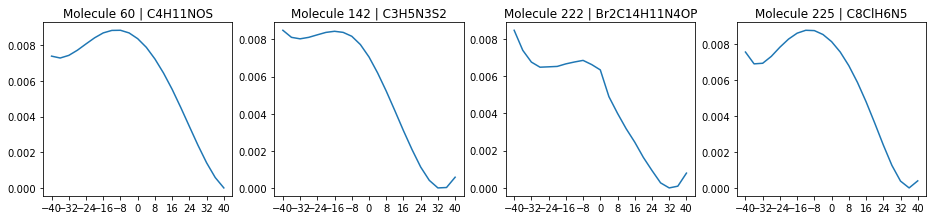

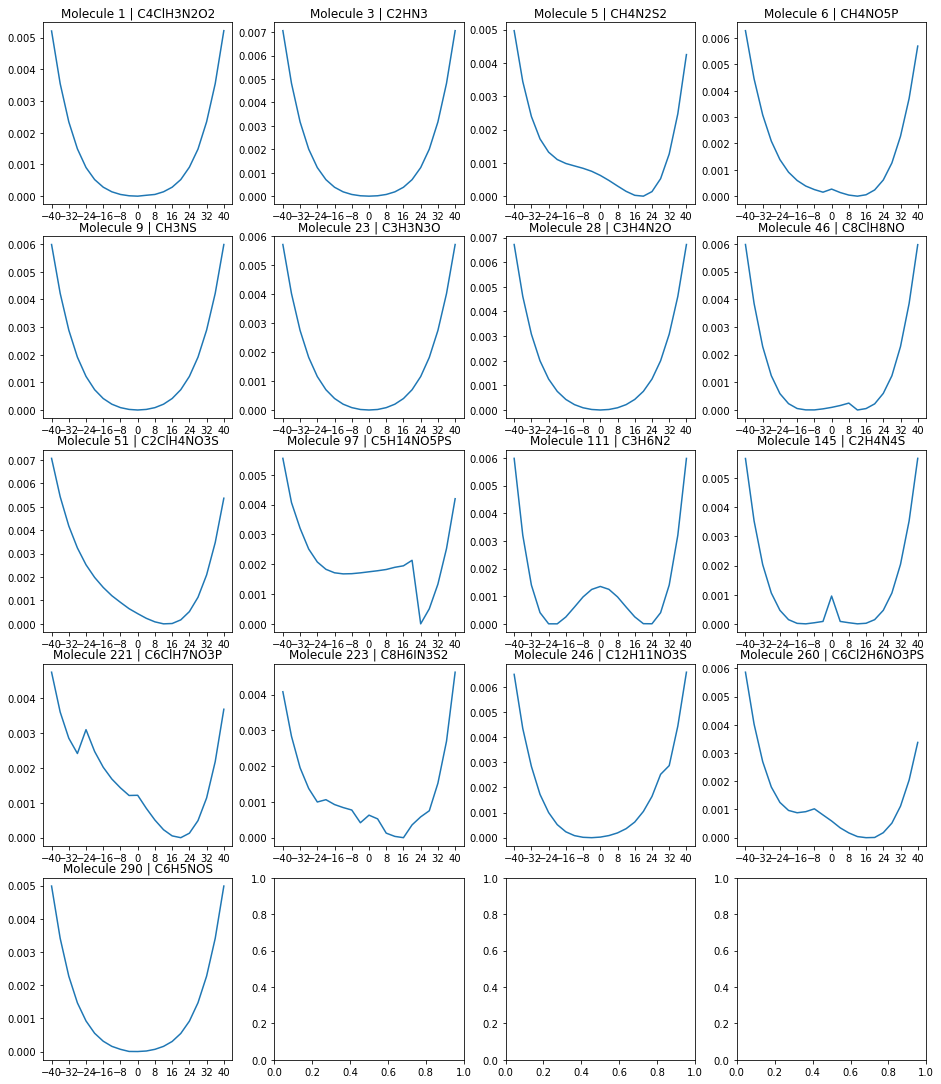

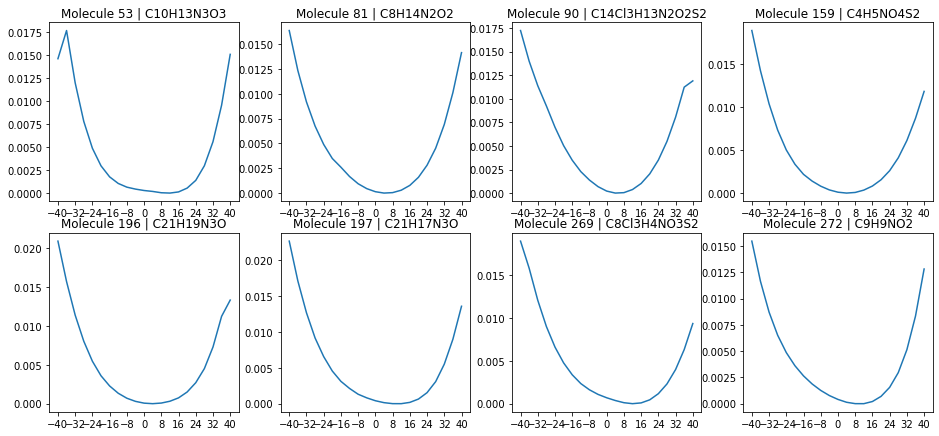

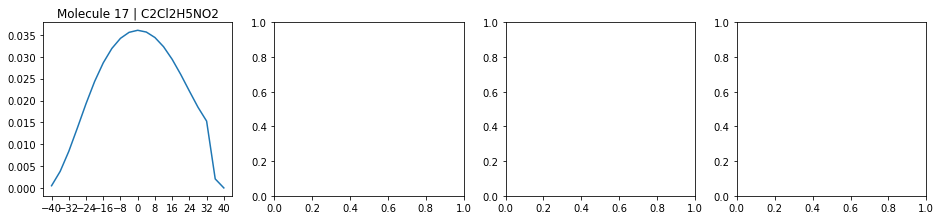

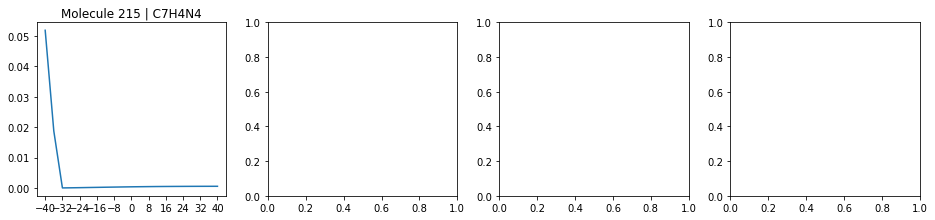

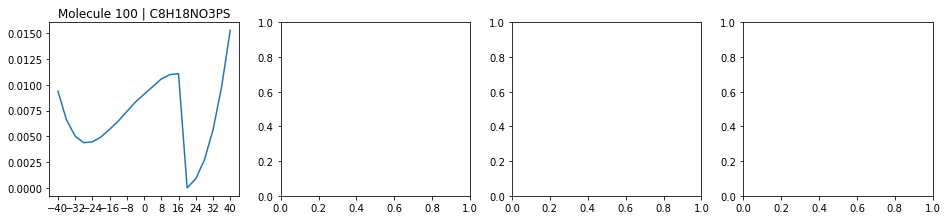

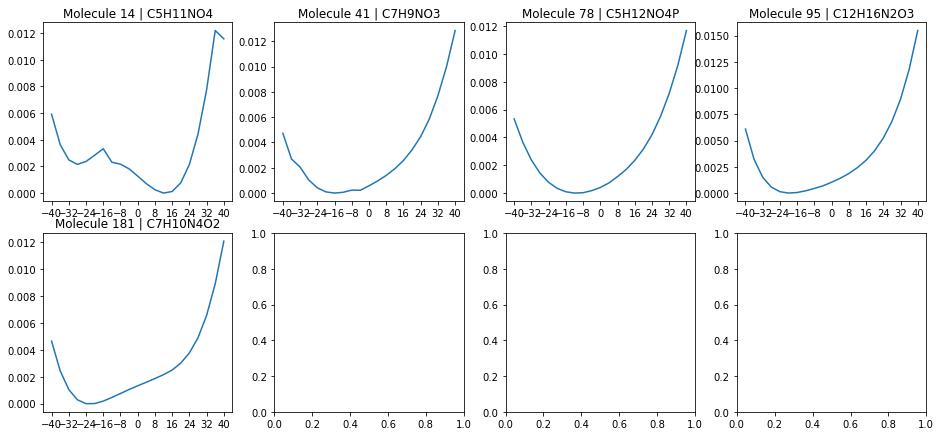

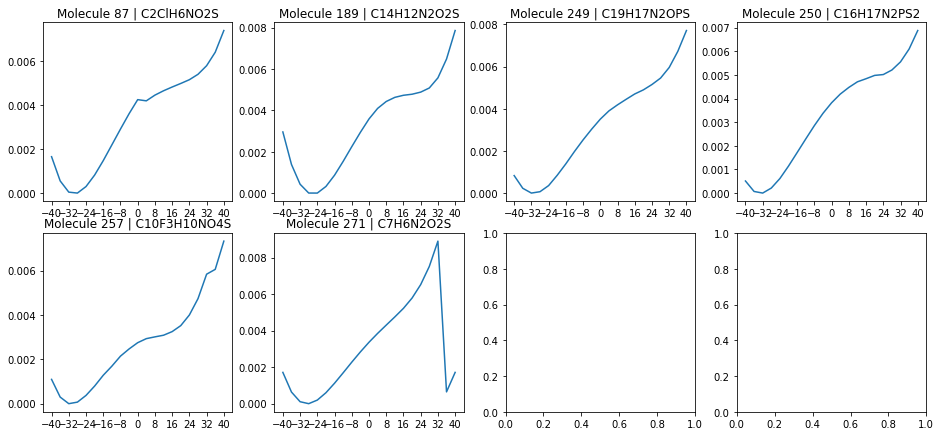

In [113]:
plot_details_for_clusters(clusters)